# **CCAI 2023 FINAL PROJECT**


***Luigi Fontana N.1000037171***


***Giuseppe Testa N.1000022605***



 

# **Goal of the project**




The goal of the final project is to train a deep learning model to perform image classification on a dataset with domain shift between training and test data.

First of all, we analyzed the dataset provided from kaggle. We have seen that the dataset was divided into train set and test set: 

*   1600 images for training
*   800 images for evaluation

The train images have different background, instead the test images have the same background.
The classification must determine between 8 different object categorie.


# **Implementation**

In [1]:
# Import Torch
import torch
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In this section we have created a class that perform the crop of the test images using the size of the relative bounding boxes inside the test.csv file.

In [2]:
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd

test_csv = pd.read_csv('/kaggle/input/ccaiunict-2023/test.csv')
test_list_csv = []
dir_img = "/kaggle/input/ccaiunict-2023/test/"

for row in test_csv.iterrows():
  test_list_csv.append(row[1])

#Instantiate custom class dataset
class testDataset(Dataset):
   def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

   def __len__(self):
        return len(self.image_paths)

   def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = Image.open(dir_img + image_path)
        coordinates = test_list_csv[index]
        
        x1=coordinates[1]
        y1=coordinates[2]
        x2=coordinates[3]
        y2=coordinates[4]
 
        cropped_image = image.crop((x1, y1, x2, y2))

        # Preprocess the image with trasform 
        if self.transform:
          cropped_image = self.transform(cropped_image)

        # Return the preprocessed image
        return cropped_image

In this section we have created a class that perform the crop of the train images using the size of the relative bounding boxes inside the train.csv file.

In [3]:
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd

train_csv = pd.read_csv('/kaggle/input/ccaiunict-2023/train.csv')
train_list_csv = []

for row in train_csv.iterrows():
  train_list_csv.append(row[1])

#Instantiate custom class dataset
class trainDataset(Dataset):
   def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

   def __len__(self):
        return len(self.image_paths)

   def __getitem__(self, index):
        image_path = self.image_paths[index]
        
        image = Image.open(image_path)
        coordinates = train_list_csv[index]
        
        x1=coordinates[1]
        y1=coordinates[2]
        x2=coordinates[3]
        y2=coordinates[4]
        label = coordinates[5]

        cropped_image = image.crop((x1, y1, x2, y2))

        # Preprocess the image with trasform
        if self.transform:
          cropped_image = self.transform(cropped_image)


        # Return the preprocessed image and the label
        return cropped_image, label

In this section we perform the data augmentation, which is needed for increase the size of the training set images to do a better train and to avoid overfit.
After that we divide the train dataset for having the validation set which is needed for knowing when to stop the training. 
Finally we prepare the data for the training.

In [4]:
# Imports
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import os
from glob import glob
import random

root_dir = "/kaggle/input/ccaiunict-2023"
train_paths = []

# Data loading options
batch_size = 64
load_size = 350
crop_size = 350
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

# Train transform
#Data augmentation
train_transform = T.Compose([
    T.Resize(load_size),
    T.RandomCrop(crop_size),
    T.RandomHorizontalFlip(), 
    T.ToTensor(),
    T.Normalize(mean=norm_mean, std=norm_std)
])

# Test transform
test_transform = T.Compose([
    T.Resize(load_size),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(mean=norm_mean, std=norm_std)
])

train_path = "/kaggle/input/ccaiunict-2023/train/"
train_list = sorted(os.listdir('/kaggle/input/ccaiunict-2023/train'))

for item in train_list:
  file_list = sorted(os.listdir(train_path + item))
  for file in file_list:
    image_path = train_path + item +"/"+ file
    train_paths.append(image_path)

load_dataset = trainDataset(train_paths, train_transform)

num_train = len(load_dataset)
# List of indexes on the training set
train_idx = list(range(num_train))

# Shuffle training set
random.shuffle(train_idx)

# Validation fraction
val_frac = 0.2
# Compute number of samples
num_val = int(num_train*val_frac)
num_train = num_train - num_val
# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

# Split train_dataset into training and validation
val_dataset = Subset(load_dataset, val_idx)
train_dataset = Subset(load_dataset, train_idx)

test_list = sorted(os.listdir('/kaggle/input/ccaiunict-2023/test'))
test_dataset = testDataset(test_list, test_transform)

# Get number of classes (we'll need it in the model)
#num_classes = len(load_dataset.classes)

# Print dataset statistics
#print(f"Num. classes: {num_classes}")
print(f"Num. train samples: {len(train_dataset)}")
print(f"Num. valid. samples: {len(val_dataset)}")
print(f"Num. test samples: {len(test_dataset)}")


# Instantiate data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True) 
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, num_workers=2, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=2, shuffle=False)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}


# iterate over batches
for batch in loaders['train']:
  data_inputs, data_labels = batch
  print(data_inputs.shape)
  print(data_labels.shape)
  break

Num. train samples: 1280
Num. valid. samples: 320
Num. test samples: 800
torch.Size([64, 3, 350, 350])
torch.Size([64])


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

Here we have found the number of features maps and the size of each feature map at the last convolutional layer.
We decide to use the convolutional neural network AlexNet with pretrained weight. Here we have tested the best combinations for adding our layers. 

In [6]:
# Define fine-tuned model tmp
class FineTunedAlexNet_tmp(nn.Module):  
    def __init__(self):
        super().__init__()
        # Load AlexNet model
        alexnet = models.alexnet(weights=("pretrained", models.AlexNet_Weights.IMAGENET1K_V1))
        self.features = alexnet.features
        # Add our layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # L 2
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.conv_layers(x)
        return x

model = FineTunedAlexNet_tmp()
test_x = train_dataset[0][0].unsqueeze(0)
out_size = model(test_x).size()
print(f"Out feature maps: {out_size} => out features: {out_size[1]*out_size[2]*out_size[3]}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 79.3MB/s] 


Out feature maps: torch.Size([1, 1024, 2, 2]) => out features: 4096


Here we add the fully connected layer to classify the 8 classes.
We have used Batchnorms and Dropout layers to avoid overfit.

In [7]:
class FineTunedAlexNet(nn.Module):  
    def __init__(self):
        super().__init__()
        # Load AlexNet model
        alexnet = models.alexnet(weights=("pretrained", models.AlexNet_Weights.IMAGENET1K_V1))
        self.features = alexnet.features
        # Add layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # L 2
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(1024 * 2 * 2, 512),
          nn.ReLU(inplace=True),
          nn.Linear(512, 8)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x) 
        return x

In [8]:
# Create model
model = FineTunedAlexNet()

In [9]:
# Test model output
model.eval()
test_input = train_dataset[0][0].unsqueeze(0)
print(test_input.size())
print("Model output size:", model(test_input).size())

torch.Size([1, 3, 350, 350])
Model output size: torch.Size([1, 8])


In [10]:
# Move model to CUDA
model.to(dev)

FineTunedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layers): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, mom

In this section we implemented the training algoritm. 

Before the training we define the optimizer and the learning rate.

Moreover we have defined the loss function.

Finally we have trained the model for 23 epochs.

In [11]:
# Create optimizer
import torch.optim as optim 
optimizer = optim.Adam(model.parameters(), lr=0.00001) 

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Initialize training history

avg_loss_history = {"train": [], "val": []}
avg_accuracy_history = {"train": [], "val": []}

# Initialize best validation accuracy and test accuracy at best validation accuracy
best_val_accuracy = 0
test_accuracy_at_best_val = 0

torch.cuda.empty_cache()

# Start training

for epoch in range(23): 
    # Initialize variables for computing average loss/accuracy
    ca_loss = {"train": 0, "val": 0}
    ca_accuracy = {"train": 0, "val": 0}
    for split in ["train", "val"]:
        # Set network mode (train or eval)
        if split == "train":
          model.train()
        else: 
          model.eval()
        for (input, labels) in loaders[split]:
            # Move to CUDA
            input = input.to(dev)
            labels = labels.to(dev)
            # Compute loss
            pred = model(input)
            loss = criterion(pred, labels)
            # Update variables for average epoch loss
            ca_loss[split] += loss.item()
            # Compute accuracy
            _,pred_labels = pred.max(1)
            batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
            # Update variables for average epoch accuracy
            ca_accuracy[split] += batch_accuracy
            # Backward and optimize
            if split == "train":
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
    # Compute average epoch loss/accuracy
    epoch_avg_loss = {split: ca_loss[split]/len(loaders[split]) for split in ["train", "val"]}
    epoch_avg_accuracy = {split: ca_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
    # Append average values to history lists
    for split in ["train", "val"]:
        avg_loss_history[split].append(epoch_avg_loss[split])
        avg_accuracy_history[split].append(epoch_avg_accuracy[split])
    # Print info
    print(f"Epoch {epoch+1}:",
          f"TrL={epoch_avg_loss['train']:.4f},",
          f"TrA={epoch_avg_accuracy['train']:.4f},",
          f"VL={epoch_avg_loss['val']:.4f},",
          f"VA={epoch_avg_accuracy['val']:.4f},")

Epoch 1: TrL=1.8698, TrA=0.3414, VL=1.7754, VA=0.7031,
Epoch 2: TrL=1.2319, TrA=0.7375, VL=1.1253, VA=0.8719,
Epoch 3: TrL=0.7925, TrA=0.9023, VL=0.6515, VA=0.9531,
Epoch 4: TrL=0.5052, TrA=0.9508, VL=0.4118, VA=0.9719,
Epoch 5: TrL=0.3305, TrA=0.9602, VL=0.2772, VA=0.9750,
Epoch 6: TrL=0.2321, TrA=0.9758, VL=0.1886, VA=0.9844,
Epoch 7: TrL=0.1648, TrA=0.9805, VL=0.1523, VA=0.9812,
Epoch 8: TrL=0.1293, TrA=0.9859, VL=0.1259, VA=0.9812,
Epoch 9: TrL=0.0947, TrA=0.9953, VL=0.1070, VA=0.9875,
Epoch 10: TrL=0.0783, TrA=0.9938, VL=0.0866, VA=0.9906,
Epoch 11: TrL=0.0654, TrA=0.9961, VL=0.0775, VA=0.9906,
Epoch 12: TrL=0.0525, TrA=0.9961, VL=0.0737, VA=0.9906,
Epoch 13: TrL=0.0437, TrA=0.9977, VL=0.0670, VA=0.9875,
Epoch 14: TrL=0.0384, TrA=0.9984, VL=0.0581, VA=0.9906,
Epoch 15: TrL=0.0324, TrA=1.0000, VL=0.0536, VA=0.9938,
Epoch 16: TrL=0.0281, TrA=1.0000, VL=0.0542, VA=0.9875,
Epoch 17: TrL=0.0275, TrA=0.9984, VL=0.0534, VA=0.9875,
Epoch 18: TrL=0.0209, TrA=1.0000, VL=0.0451, VA=0.9938,
E

In [12]:
from matplotlib import pyplot as plt

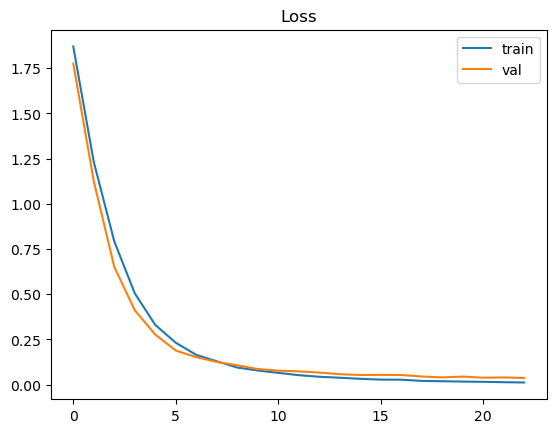

In [13]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val"]:
    plt.plot(avg_loss_history[split], label=split)
plt.legend()
plt.show()

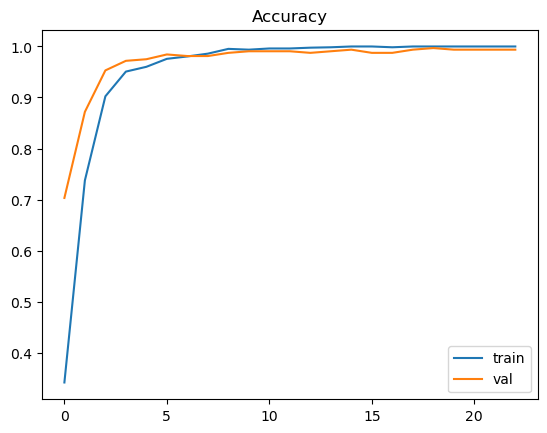

In [14]:
# Plot accuracy history
plt.title("Accuracy") 
for split in ["train", "val"]:
    plt.plot(avg_accuracy_history[split], label=split)
plt.legend()
plt.show()

This code was used for the creation of the kaggle submission file.

In [15]:
import csv

with open('/kaggle/working/submission.csv', 'a', newline='') as csvfile:
    # Create a CSV writer object
    fieldnames = ['Image', 'Class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerow({'Image': "image", 'Class': "class"})
    for idx in range(800):
      input = test_dataset[idx]
      # Predict class
      model.eval()
      with torch.no_grad():
          output = model(input.unsqueeze(0).to(dev))
      _,pred = output.max(1)
      pred = pred.item()
      
      # Write the data to the CSV file
      writer.writerow({'Image': test_list[idx], 'Class': pred})
      print(f"File {test_list[idx]} Class{pred}")

File 000.jpg Class3
File 001.jpg Class0
File 002.jpg Class3
File 003.jpg Class4
File 004.jpg Class0
File 005.jpg Class5
File 006.jpg Class0
File 007.jpg Class7
File 008.jpg Class0
File 009.jpg Class2
File 010.jpg Class2
File 011.jpg Class0
File 012.jpg Class4
File 013.jpg Class0
File 014.jpg Class7
File 015.jpg Class6
File 016.jpg Class2
File 017.jpg Class4
File 018.jpg Class6
File 019.jpg Class2
File 020.jpg Class1
File 021.jpg Class5
File 022.jpg Class5
File 023.jpg Class1
File 024.jpg Class0
File 025.jpg Class7
File 026.jpg Class4
File 027.jpg Class0
File 028.jpg Class5
File 029.jpg Class5
File 030.jpg Class4
File 031.jpg Class1
File 032.jpg Class1
File 033.jpg Class5
File 034.jpg Class4
File 035.jpg Class2
File 036.jpg Class2
File 037.jpg Class6
File 038.jpg Class0
File 039.jpg Class6
File 040.jpg Class6
File 041.jpg Class1
File 042.jpg Class4
File 043.jpg Class4
File 044.jpg Class4
File 045.jpg Class0
File 046.jpg Class0
File 047.jpg Class6
File 048.jpg Class3
File 049.jpg Class0
